In [7]:
t1_filename = 'BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_t1.nii.gz'
t1ce_filename = 'BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_t1ce.nii.gz'
t2_filename = 'BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_t2.nii.gz'
flair_filename = 'BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_flair.nii.gz'
seg_filename = 'BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_TCIA02_222_1/Brats18_TCIA02_222_1_seg.nii.gz'

In [8]:
import SimpleITK as sitk
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [3]:
t1_image = sitk.ReadImage(t1_filename)
t1ce_image = sitk.ReadImage(t1ce_filename)
t2_image = sitk.ReadImage(t2_filename)
flair_image = sitk.ReadImage(flair_filename)
seg_image = sitk.ReadImage(seg_filename)

In [4]:
t1_arr = sitk.GetArrayFromImage(t1_image)
t1ce_arr = sitk.GetArrayFromImage(t1ce_image)
t2_arr = sitk.GetArrayFromImage(t2_image)
flair_arr = sitk.GetArrayFromImage(flair_image)
seg_arr = sitk.GetArrayFromImage(seg_image)

In [5]:
t1_arr.shape, t2_arr.shape

((155, 240, 240), (155, 240, 240))

In [6]:
t1 = torch.from_numpy(t1_arr)
t1ce = torch.from_numpy(t1ce_arr)
t2 = torch.from_numpy(t2_arr)
flair = torch.from_numpy(flair_arr)
seg = torch.from_numpy(seg_arr)

In [7]:
t1 = t1.unsqueeze(0)
#add a dimension to tensor
t1ce = t1ce.unsqueeze(0)
t2 = t2.unsqueeze(0)
flair = flair.unsqueeze(0)

In [8]:
t1.shape, t2.shape

(torch.Size([1, 155, 240, 240]), torch.Size([1, 155, 240, 240]))

In [9]:
vol = torch.cat((t1, t1ce, t2, flair), 0).to(dtype=torch.float32)
vol.shape

torch.Size([4, 155, 240, 240])

In [15]:
import os
from torch.utils.data import Dataset

class BRATSDataset(Dataset):
    def __init__(self, dirs):
        self.dirs = dirs
    
    def get_filename(self, path, casename, img_type):
        return os.path.join(path, '%s_%s.nii.gz' % (casename, img_type))
    
    def __getitem__(self, index):
        path = self.dirs[index]
        casename = os.path.basename(os.path.normpath(path))
        img_types = ['t1', 't1ce', 't2', 'flair']
        img_filenames = [self.get_filename(path, casename, el) for el in img_types]
        seg_filename = self.get_filename(path, casename, 'seg')
        imgs = [sitk.ReadImage(el) for el in img_filenames]
        arrs = [sitk.GetArrayFromImage(el) for el in imgs]
        tensors = [torch.from_numpy(el) for el in arrs]
        tensors = [el.unsqueeze(0) for el in tensors]
        vol = torch.cat(tensors, 0).to(dtype=torch.float32)
        seg = sitk.ReadImage(seg_filename)
        seg = torch.from_numpy(sitk.GetArrayFromImage(seg))
        return vol, seg
    
    def __len__(self):
        return len(self.dirs)

In [19]:
from glob import glob
dataset = BRATSDataset(glob('BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/*2013*'))
for d, _ in dataset:
    print(d.shape)

torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])
torch.Size([4, 155, 240, 240])


In [ ]:
vol, mask = dataset[0]

In [ ]:
vol.shape, mask.shape

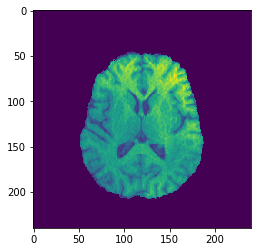

In [5]:
for vol,mask in dataset:
    plt.imshow(vol[0, 77].cpu().numpy())
plt.show()

In [12]:
from torch.utils.data import Dataset, DataLoader

def dice_loss(pred, target):
    eps = 1E-4
    pred = pred.squeeze()
    target = target.squeeze()
    and_ = torch.sum(pred * target)
    cardinality = torch.sum(pred) + torch.sum(target)
    dice = 1.0 - (2 * and_ + eps) / (cardinality + eps)
    return dice

def init_params(el):
    if type(el) in [nn.Conv2d, nn.ConvTranspose2d]:
        nn.init.kaiming_normal_(el.weight)
        nn.init.normal_(el.bias)


class UNet(nn.Module):

    def __init__(self, n1, n_out_chs):
        super(UNet, self).__init__()

        n2 = 2*n1
        n3 = 2*n2
        n4 = 2*n3

        k1 = 3
        self.pool_size = (2, 2)

        self.conv1 = nn.Conv2d(1, n1, kernel_size=(k1, k1), padding=(1,1))
        self.conv2 = nn.Conv2d(n1, n2, kernel_size=(k1,k1), padding=(1,1))
        self.conv3 = nn.Conv2d(n2, n3, kernel_size=(k1,k1), padding=(1,1))
        self.conv4 = nn.Conv2d(n3, n4, kernel_size=(k1,k1), padding=(1,1))

        self.outconv3 = nn.Conv2d(n4+n3, n3, kernel_size=(k1,k1), padding=(1,1))
        self.outconv2 = nn.Conv2d(n3+n2, n2, kernel_size=(k1,k1), padding=(1,1))
        self.outconv1 = nn.Conv2d(n2+n1, n_out_chs, kernel_size=(1,1))

        self.apply(init_params)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x1 = x

        x = F.max_pool2d(x, self.pool_size, stride=self.pool_size)

        x = F.relu(self.conv2(x))
        x2 = x

        x = F.max_pool2d(x, self.pool_size, stride=self.pool_size)

        x = F.relu(self.conv3(x))
        x3 = x

        x = F.max_pool2d(x, self.pool_size, stride=self.pool_size)

        x = F.relu(self.conv4(x))

        x = F.upsample(x, scale_factor=2)

        x = torch.cat((x, x3), 1)
        x = F.relu(self.outconv3(x))

        x = F.upsample(x, scale_factor=2)

        x = torch.cat((x, x2), 1)
        x = F.relu(self.outconv2(x))

        x = F.upsample(x, scale_factor=2)

        x = torch.cat((x, x1), 1)
        x = F.sigmoid(self.outconv1(x))

        return x
def train():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    boxes_train_dataset = BRATSDataset(glob('BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_C*'))
    train_loader = DataLoader(dataset=boxes_train_dataset, batch_size=16)

    boxes_test_dataset = BRATSDataset(glob('BraTS2018/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2'))
    test_loader = DataLoader(dataset=boxes_test_dataset, batch_size=16)

    model = UNet(8, 1).to(device)

    criterion = dice_loss

    learning_rate = 0.001
    num_epochs = 50

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    num_steps = len(train_loader)

    for epoch in range(num_epochs):
        for i, (images, masks) in enumerate(train_loader):

            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i == 0:
                test_iter = iter(test_loader)
                images, masks = test_iter.next()
                outputs = model(images)

                loss = criterion(outputs, masks)
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, num_steps, float(loss)))

                plt_img = torch.cat((images[0].detach().squeeze(), outputs[0].detach().squeeze(), masks[0].detach().squeeze()), 1)
                plt.imshow(plt_img.cpu().numpy(), cmap=plt.cm.Greys_r)
                plt.show()
train()



RuntimeError: expected stride to be a single integer value or a list of 3 values to match the convolution dimensions, but got stride=[1, 1]